# Machine Learning Exploratory Data Analysis

Whilst basic EDA is often interesting on its own merits. It can often be more useful to build a statistical model and understand how the model came to its conclusions.
This can reduce the amount of time spent on variables that overall do not matter and focus on the ones that do. Further, it can also draw out insights from the data that basic EDA didn't pick up.

Importing the requisite libraries

In [1]:
#Standard lib
import numpy as np
import pandas as pd
import pathlib

#Vis
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')

#Model creation and analyis
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss,r2_score
from sklearn.externals import joblib

#Partial Dependence plots
import pdpbox.pdp as pdp

#Helper func
from helper_funcs.feature_engineering import split_df 
from helper_funcs.interpretation import prettified_confusion, plot_learning_curve

C:\Users\lubennett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Read in the training data set.

In [2]:
data_path = pathlib.Path(".") / "data" /  "stratified_sets" /"train.csv"
df_raw = pd.read_csv(data_path,low_memory = False)

Check the top 5 rows of the dataframe

In [3]:
df_raw.head()

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
0            7.3              0.49         0.10            2.60      0.068   
1           10.4              0.24         0.49            1.80      0.075   
2            6.2              0.60         0.08            2.00      0.090   
3            9.1              0.29         0.33            2.05      0.063   
4           12.3              0.50         0.49            2.20      0.089   

   free.sulfur.dioxide  total.sulfur.dioxide  density    pH  sulphates  \
0                  4.0                  14.0  0.99562  3.30       0.47   
1                  6.0                  20.0  0.99770  3.18       1.06   
2                 32.0                  44.0  0.99490  3.45       0.58   
3                 13.0                  27.0  0.99516  3.26       0.84   
4                  5.0                  14.0  1.00020  3.19       0.44   

   alcohol  quality  
0     10.5        5  
1     11.0        6  
2     10.5        5  
3     11.7        7  
4      9.6        5

### Validation Set

We can now create a train and validation set.  
Here we have the choice of using a stratified sample, a random sample or just a single split in the data.
As we are only doing EDA. I will just use a random set.   
This can be easily done with a permutation or a random choice.

We need to split our data into the validation and training sets as well as the dependant and independent sets.  
For cleanliness, I have created a helper function "split_df" to do so.

In [4]:
np.random.seed(2)
perm = np.random.permutation(df_raw.shape[0])

We can then take the indexes to make a subset.

In [5]:
train_size = int(df_raw.shape[0] * 0.8)
train_idx = perm[:train_size]
test_idx = perm[train_size:]

Check our set sizes to see if they make sense.

They look to be okay.

In [6]:
print(f"Training set size: {train_size}")
print(f"Validation set size: {df_raw.shape[0] - train_size}")

Training set size: 1151
Validation set size: 288


We can then use 'split df' from the helper functions which will split the y variable from both data sets. 

Further, the function will define the training and validation sets based on the passed indices.

In [7]:
X_train, y_train, X_valid, y_valid = split_df(df_raw, train_idx,test_idx,y_var = "quality")

### Basic Model

To better understand the data we begin by creating a basic model.  
Before doing so, the task must first be defined I.e Is it a regression problem or a classification problem.
  
In this case, a classifier was chosen for two reasons    

 - The dependent variable is discrete. That is the dependent variable is a Natural Number defined on the set between between 0 and 10. However, this is a weak assumption as we could simply convert to integers after training a regression model.

- More importantly, there is not a well-defined norm or a metric over the space. Whilst it is clear that the quality has a defined relation and is ordinal, such that a score of 8 is better than a 7. It may be prudent to class the distance between a 7 and 8 score and a 3 to 4 score the same, particularly given the subjective nature of the quality score. If it is not then the L2 norm (Euclidean distance) over the space that is required in a regression MSE standard loss function does not make sense. From this perspective a disrete loss function such as Cross Entropy is more intuitive.

As such the topological properties of the quality, variable makes the task closer to a classifier task and as such a classifier model will be used. For the Machine Learning EDA, a Random forest classifier will be used given its relative simplicity and ease of interpretability. 

In [8]:
model = RandomForestClassifier(n_estimators = 20, n_jobs = -1, random_state = 2)

Fit the training set

In [9]:
model.fit(X_train,y_train);

Checking the accuracy on the training set and validation sets. We look to have a good model  
However on the validation set. It looks less so.  
Clearly our model has too much capacity and is overfitting

In [10]:
print("Training accuracy\n______________________")
print(f"{accuracy_score(y_train,model.predict(X_train)).round(4) * 100}%")

print("\nValidation score\n______________________")
print(f"{accuracy_score(y_valid,model.predict(X_valid).round(2)).round(4) * 100}%")

print("\nTraining log loss\n______________________")
print(f"{log_loss(y_train,model.predict_proba(X_train)).round(4)}")

print("\nValidation log loss\n______________________")
print(f"{log_loss(y_valid,model.predict_proba(X_valid)).round(4)}")
print()

Training accuracy
______________________
99.74%

Validation score
______________________
66.67%

Training log loss
______________________
0.1944

Validation log loss
______________________
1.3552



### A Slightly improved model

Given the model is only to be used for EDA. It is only necessary to build a reasonable model for interpretability and leave optimisation for later.  
Whilst not a great model. An accuracy score of 69% is decent enough to get a feel for the data 

In [11]:
model = RandomForestClassifier(n_jobs = -1, n_estimators = 20, min_samples_leaf = 1, max_features = 0.5, random_state = 2)
model.fit(X_train,y_train);

With a manually tuned model. We have the following set of hyperparameters

In [12]:
n_estimators= 20,
criterion='gini',
max_depth=None,
min_samples_split=2,
min_samples_leaf=1,
min_weight_fraction_leaf=0.0,
max_features = 0.5,
max_leaf_nodes=None,
min_impurity_decrease=0.0,
min_impurity_split=None,
bootstrap=True,
random_state=2

Validating the score

In [13]:
print("Training accuracy\n______________________")
print(f"{accuracy_score(y_train,model.predict(X_train)).round(4) * 100}%")

print("\nValidation score\n______________________")
print(f"{accuracy_score(y_valid,model.predict(X_valid).round(2)).round(4) * 100}%")

print("\nTraining log loss\n______________________")
print(f"{log_loss(y_train,model.predict_proba(X_train)).round(4)}")

print("\nValidation log loss\n______________________")
print(f"{log_loss(y_valid,model.predict_proba(X_valid)).round(4)}")
print()

Training accuracy
______________________
99.39%

Validation score
______________________
69.1%

Training log loss
______________________
0.1943

Validation log loss
______________________
1.9045



#### Learning curve - High variance

After manual tuning, the learning curve still exhibits a high variance and overfits despite attempts to reduce model capacity. This appears to be a function of a small sample size as the cross validation error has not begun to level off as the sample size has increased. 

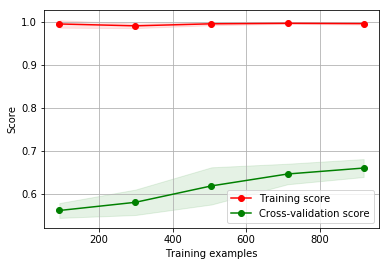

In [14]:
plot_learning_curve(model, title = None,X =  X_train, y = y_train, n_jobs=-1);
#plt.savefig("learning Curve.jpeg")

Despite not having a clearly defined metric, misclassifications that are close (however arbitrarily defined), are less erroneous than those further away. Such that a 6 misclassified as a 5 is not as bad as a 6 classified as a 2 or a 9. 

Despite the relatively low accuracy score. We should hope that erroneously classified points are close. We can check if this is so via the confusion matrix.

In plotting the confusion matrix, we can see the misclassifications (off diagonals) are generally close together with most misclassification occurring with 

- 22 6's being misclassified as 5 
- 27 5's being misclassified as 6
- 20 7's being misclassified as 6

The model, however, appears to fail in the less represented classes with only 25% of 8's correctly classified and 3's and 4's entirely misclassified.
To improve the performance of these classes we may need to experiment with weighted resampling or use boosting algorithms such as those used in a GMB's or an XGBoost model.

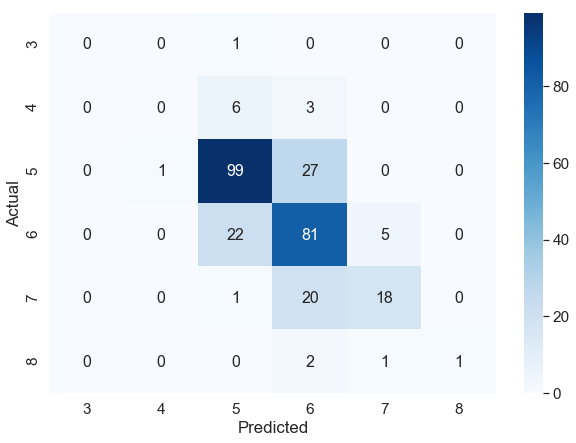

<Figure size 432x288 with 0 Axes>

In [15]:
prettified_confusion(y_valid,model.predict(X_valid),labels =[3, 4, 5, 6, 7, 8])
plt.savefig("confusion_matrix.jpg")

This can be further illistrated in the classification report

In [16]:
x = classification_report(y_valid,model.predict(X_valid),labels = [3,4,5,6,7,8])
print(x)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         9
           5       0.77      0.78      0.77       127
           6       0.61      0.75      0.67       108
           7       0.75      0.46      0.57        39
           8       1.00      0.25      0.40         4

    accuracy                           0.69       288
   macro avg       0.52      0.37      0.40       288
weighted avg       0.68      0.69      0.68       288



For replication purposes. The model will be persisted in the Models folder

In [17]:
save = True
if save:
    model_path = pathlib.Path().cwd() / "models" /  "ML_EDA_clf.pkl"
    joblib.dump(model, model_path);

Create a Load up point 

In [18]:
model_path = pathlib.Path().cwd() / "models" /  "ML_EDA_clf.pkl"
model = joblib.load(model_path)
print(model)
print()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=2, verbose=0,
                       warm_start=False)



# Feature Importance

Given our first baseline model, we can use the model to drive the EDA process.  

Lets first start with the feature importance.

In [19]:
feat_imp = pd.DataFrame(model.feature_importances_,
                        X_train.columns,columns = ["Feature importance"]
                       ).sort_values("Feature importance", ascending = False)

feat_imp

Feature importance
alcohol                         0.150277
volatile.acidity                0.120912
sulphates                       0.113482
total.sulfur.dioxide            0.104063
density                         0.087357
chlorides                       0.073303
residual.sugar                  0.072535
fixed.acidity                   0.071524
free.sulfur.dioxide             0.071303
pH                              0.071119
citric.acid                     0.064124

### Visualising feature importance

Referring back to the Basic EDA notebook.  
We find the result are generally in line with the correlation coefficients.  
That is alcohol, sulphates, citric acid, volatile acidity, total sulfur dioxide, and density are our primary drivers.  
Further, there does not seem to be any feature that can be removed without adversely affecting the model. 

Depending on the levers available to the business this may or may not be useful. At this stage, it is usually useful to ask the end-users whether this makes sense.
For instance, alcohol is the result of fermentation. Is this a lever that a firm could pull to improve their wine quality? It may be the case that to improve the alcohol content that the process will require additives that have a stronger effect in reducing the quality than the resulting additional alcohol content. 

Given the similarity between the linear correlation and the feature importance of the random forest.  
It would seem a relatively low capacity/complexity model such as a softmax logistic classifier may do well on this data set.

Typically from the feature importance, it is possible to eliminate some of the columns with redundant information. However, there are no clear candidates for removal. In this case, there are two potential routes to try and improve performance via feature selection. 

- Iterative: Use an iterative technique that searches through all combinations of features and returns the single best feature space.
- Dimensionality reduction: We can an orthogonality algorithm such as a principal component analysis to define a new feature space that is the linear combinations of the first which have similar information. If there was a reason to believe that the data was non-linear but highly correlated, an autoencoder (encoder function) could be used to derive a feature space. However, this may not be desirable if the goal is to understand the model as interpretability is difficult and as such will not be used.  

Text(0.5, 1.0, 'Feature Importance\n')

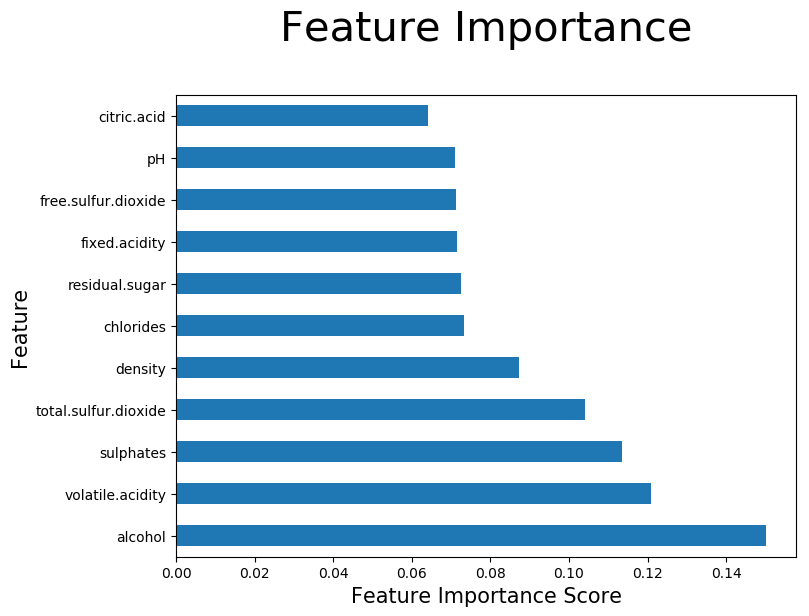

In [20]:
plt.style.use('default')
feat_imp.plot(kind="barh",figsize = [8,6],legend = False);
plt.xlabel("Feature Importance Score",size = 15)
plt.ylabel("Feature", size  =15)
plt.title("Feature Importance\n",size  = 30)
# plt.savefig("feat_imp.jpeg")

In [21]:
def plot_pdp(sample,feat,model, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model, sample, feature = feat, model_features = sample.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

## Univariate Partial Dependence Plots

Given we can see the features that have high feature importance.  
We can understand how the classifier changes its probability based on the value of feature by using a partial dependence plot.    

The partial dependence plot works by splitting the data into each of its classes (quality scores) and modifying the value of the designated feature (i.e alcohol) for all values in the feature. The features change in probability is then calculated for each point. This will give a change in probability for every row at every given value of the feature. This can be plotted as a line for every row with the feature value on the x-axis. Given this can be cluttered with so many lines, the most similar rows can be cluster to provide ease of visualisation. Further, the general trend can be estimated by taking the average (computed horizontally) of each row/line.

### Alcohol

Given the lack of data associated with the classes 3,4 and 8. We can ignore the first, second and last graphs.
We can see the plots make sense from a linear sense. In the graph 3 (class 2 in the image), the probability of choosing a quality rating of 5 increases by about 15% if the score is between 9 and 10, but falls by as much as 20% if it is above 10.5

We see almost the opposite occurring in image 4 (class 3 quality = 6). It appears that low alcohol content reduces the probability but higher content increases the probability.

It should be expected that a more stark contrast with image 5 (class 4 quality = 7) should be present. But it makes be a case of a limited data set.

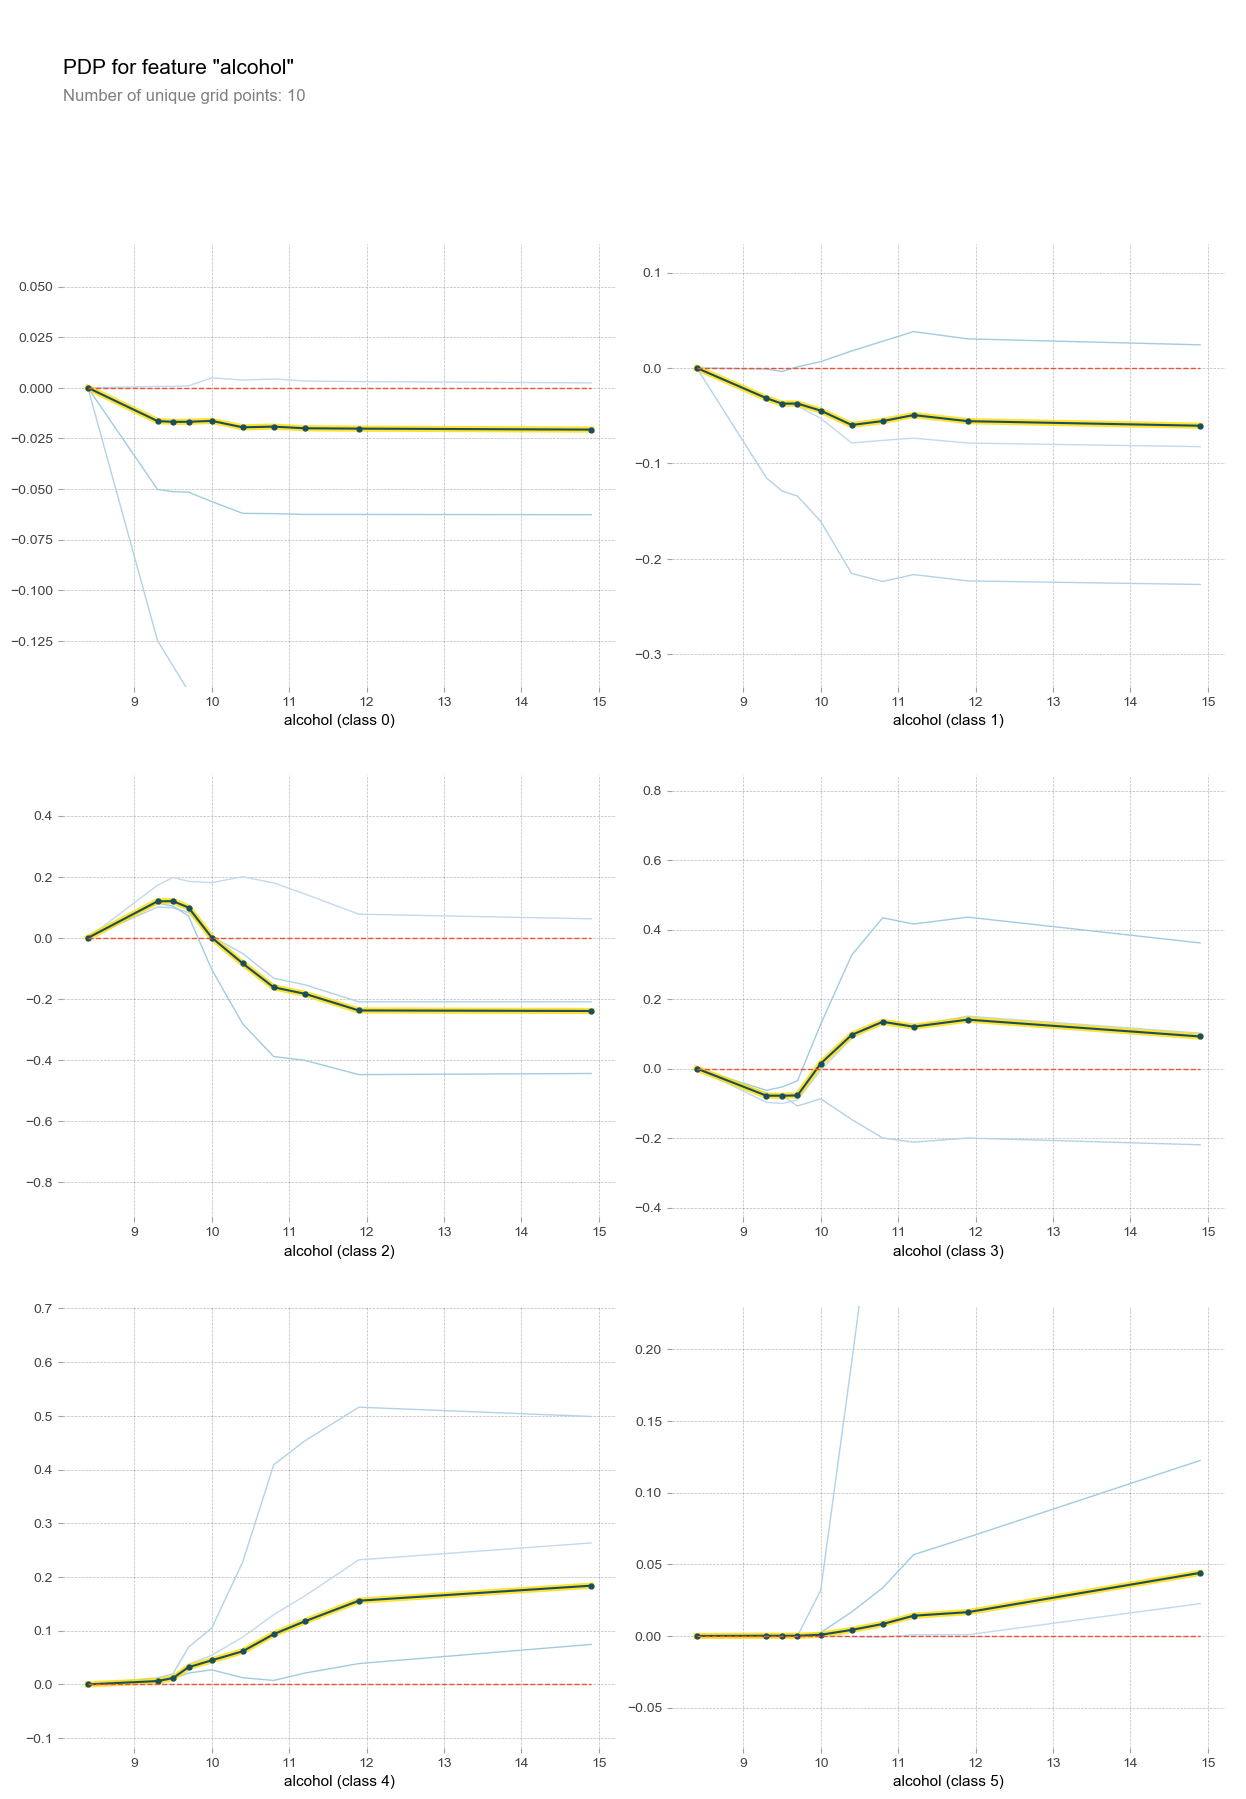

In [22]:
plot_pdp(X_train,"alcohol",model, clusters = 3);
plt.savefig("PDP_Alcohol.jpeg")

### Volatile acidity

According to the data description. volatile.acidity is "the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste".  
We can see that hypothesis plays out in the model with lower volatile acidity, in general, leading to increased probabilities of lower quality scores.

However, most of the decisions around split points are taking at lower regions of the range. Suggesting the large outlier values of volatile acidity are largely uninformative. 

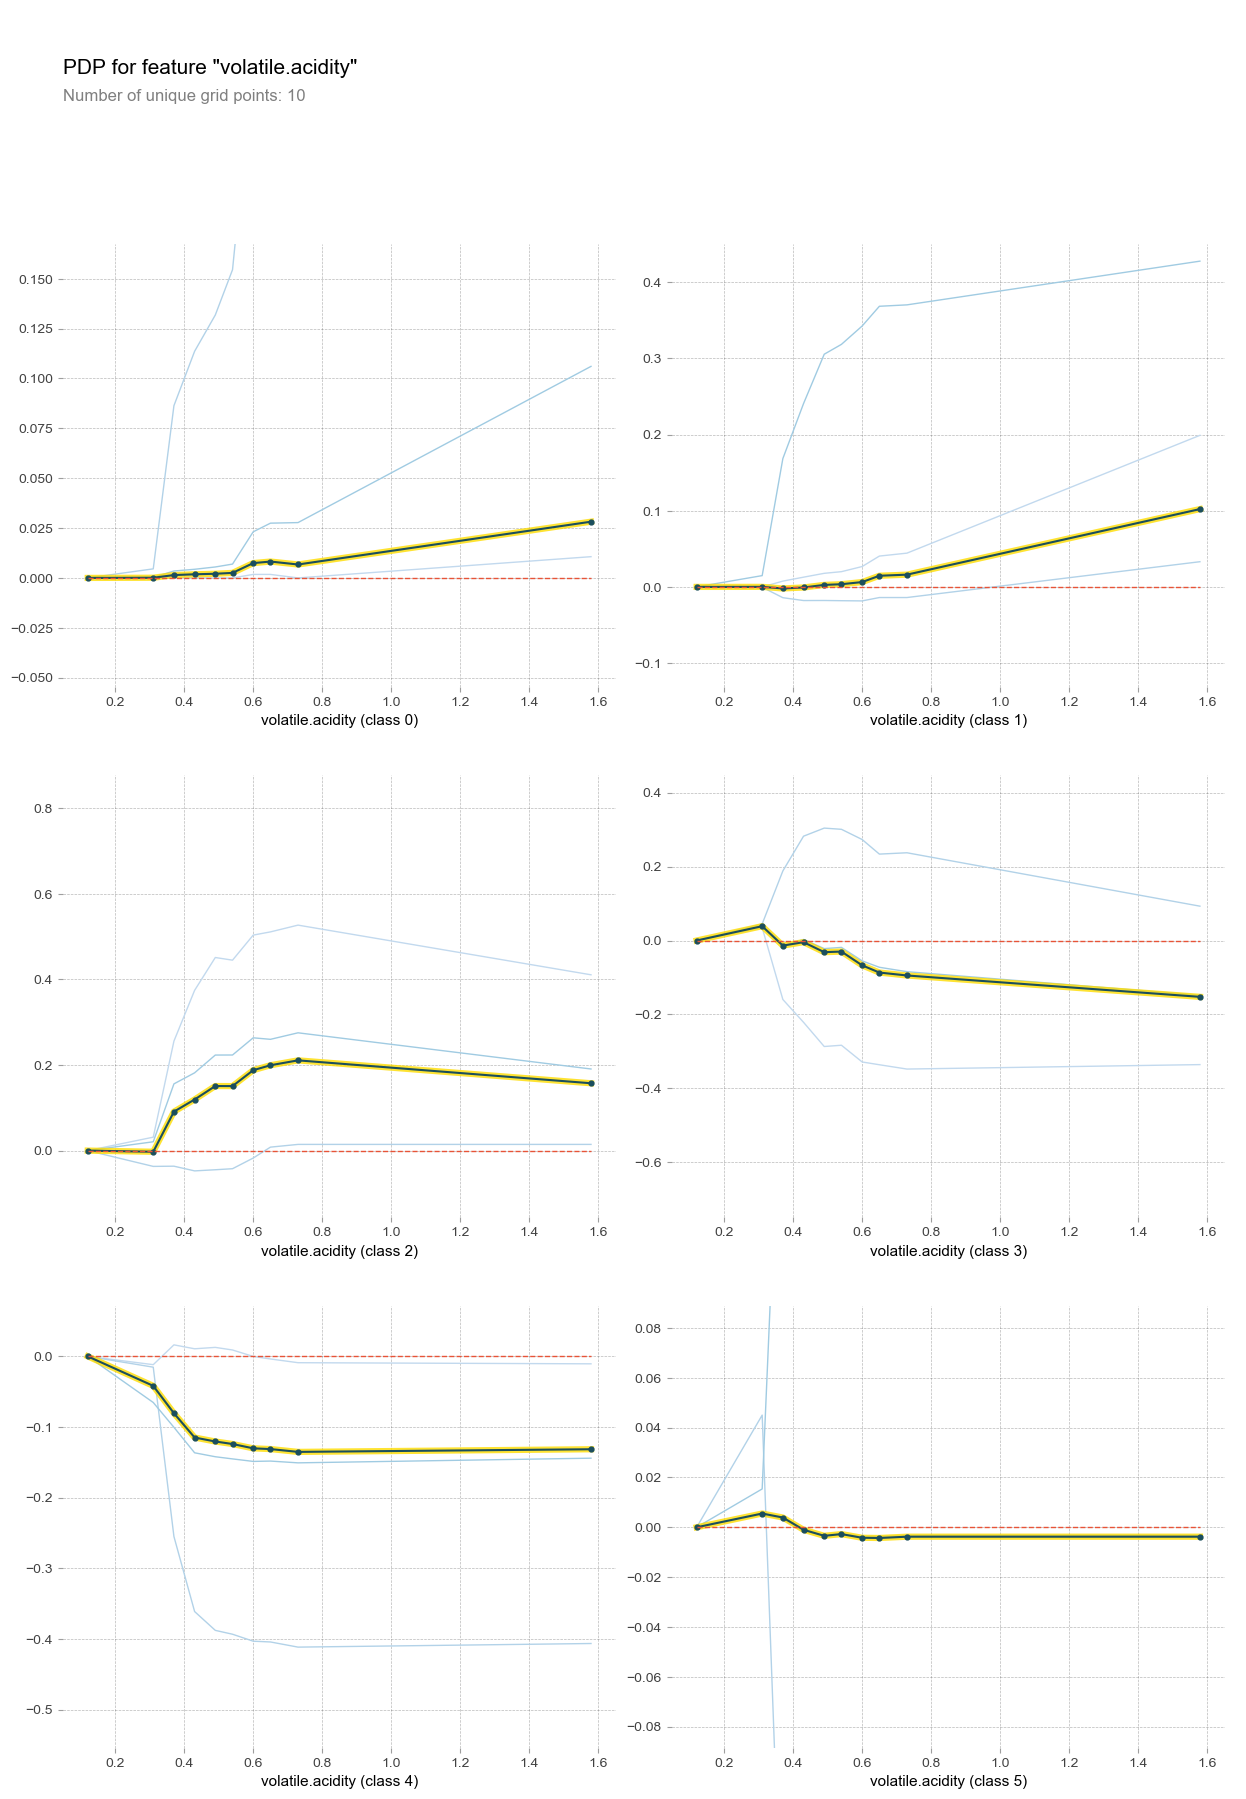

In [23]:
plot_pdp(X_train,"volatile.acidity",model,clusters = 3);
plt.savefig("PDP_volatile.acidity.jpeg")

## Bivariate Partial Dependence Plots

Bivariate partial dependence plots work by providing insight into the change in probabilities of two separate features over the given feature space through the use of a contour map. The area inside each contour depicts the probability associated with the given area. 

#### Alcohol and Sulphates
Despite alcohol and sulphates appearing to be heavily correlated.   
In the model they don't seem to interact that well. Most of the probability in each of the classes appears to be dominated by alcohol.

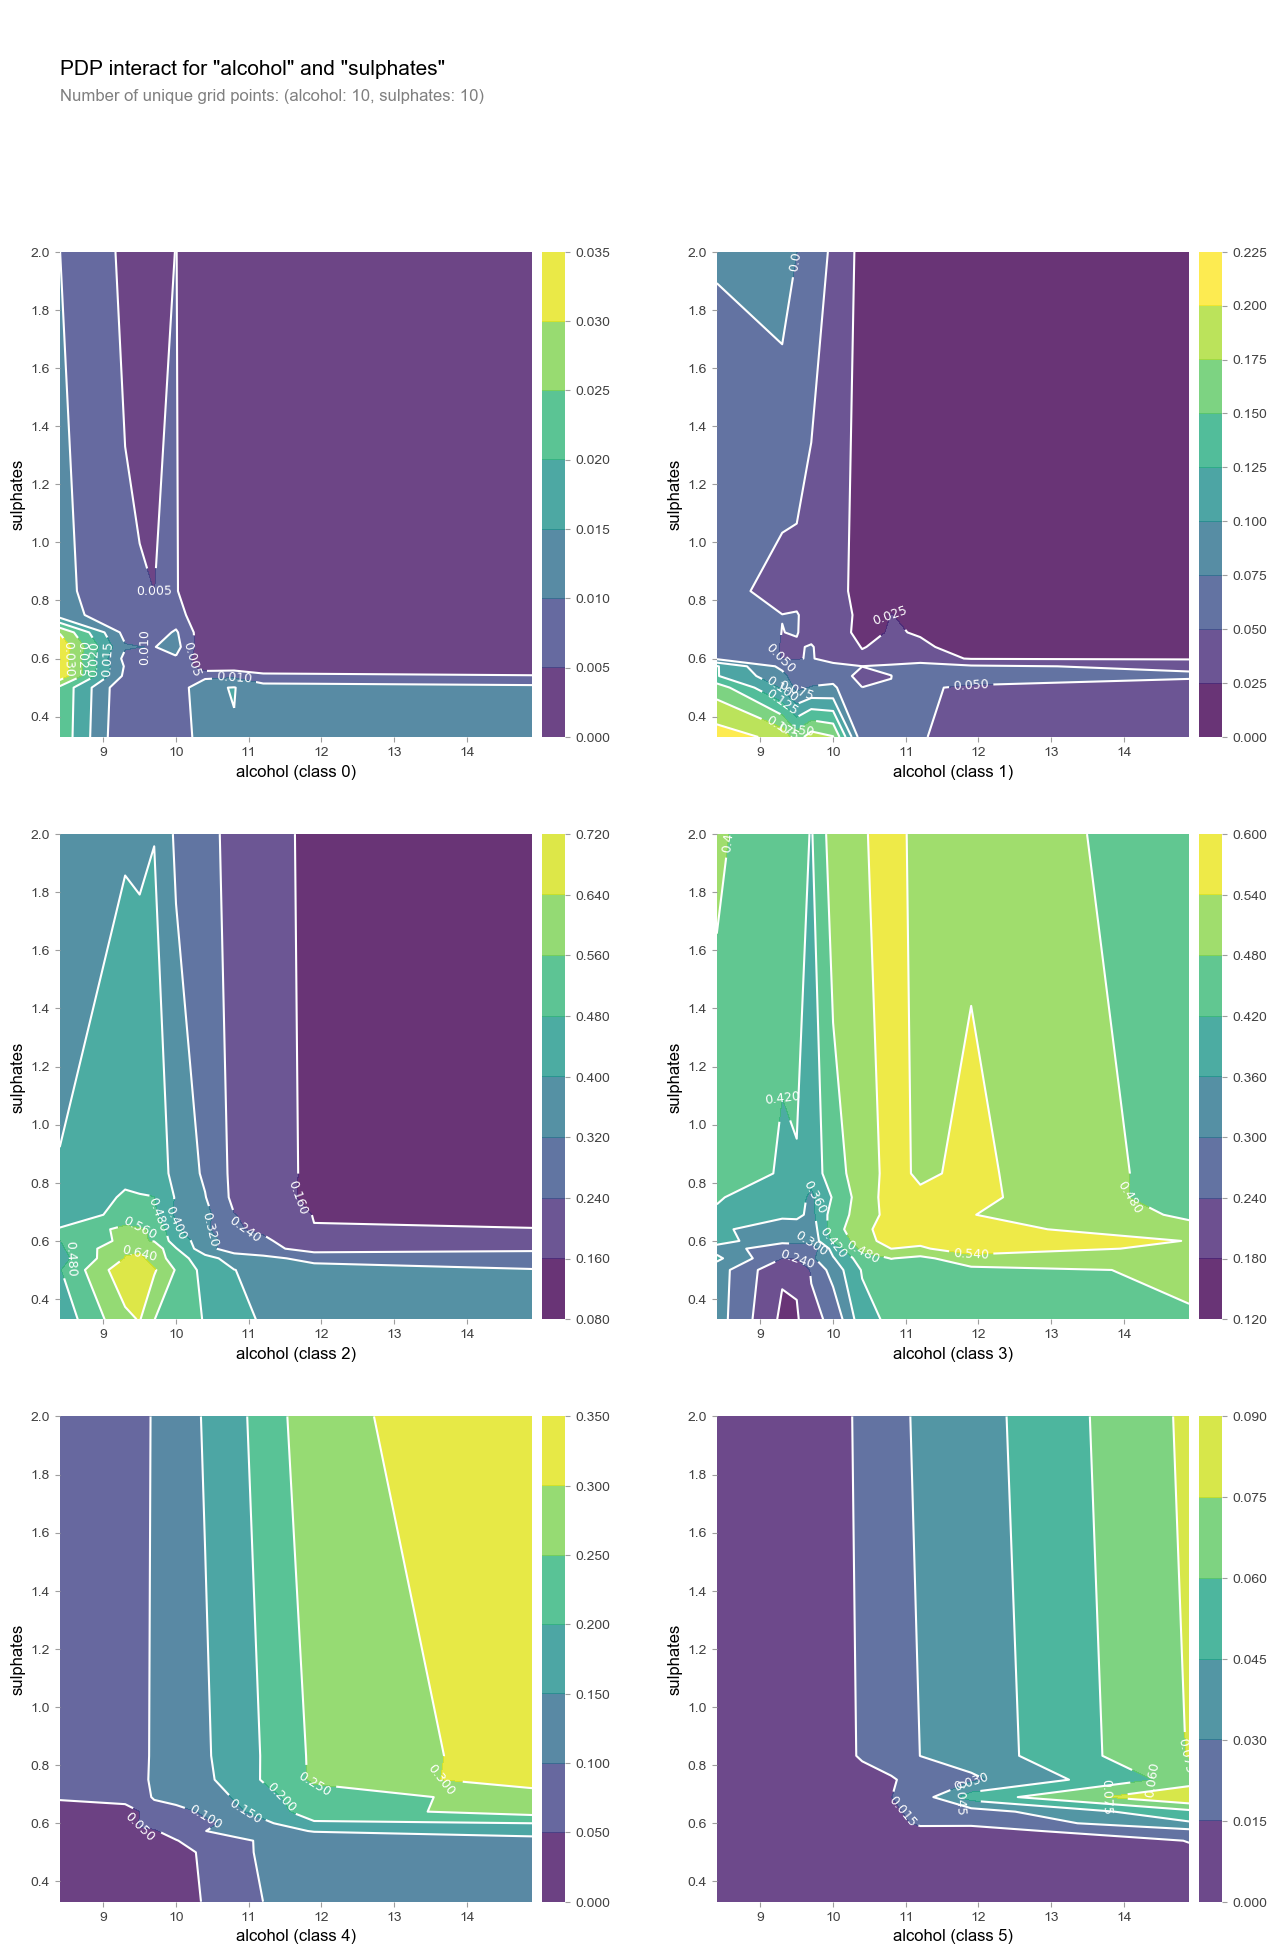

In [24]:
feats = ['alcohol', 'sulphates']
p = pdp.pdp_interact(model, X_train, X_train.columns, feats)
pdp.pdp_interact_plot(p, feats)
plt.savefig("BPDP_Alcohol_Sulphates.jpeg")

### Alcohol and volatile acidity

We can see that alcohol and volatile acidity together play a very strong role in the prediction of the model. With the model predicting very poor wines will have very high volatile acidity and low alcohol content (top left) and likewise very good wines to have a high alcohol content and low volatile acidity score.

Particularly in images 3 and 4 (quality is 5 and 6), we find that the interaction can increase the probability of each class up to 72% and 60% respectively.

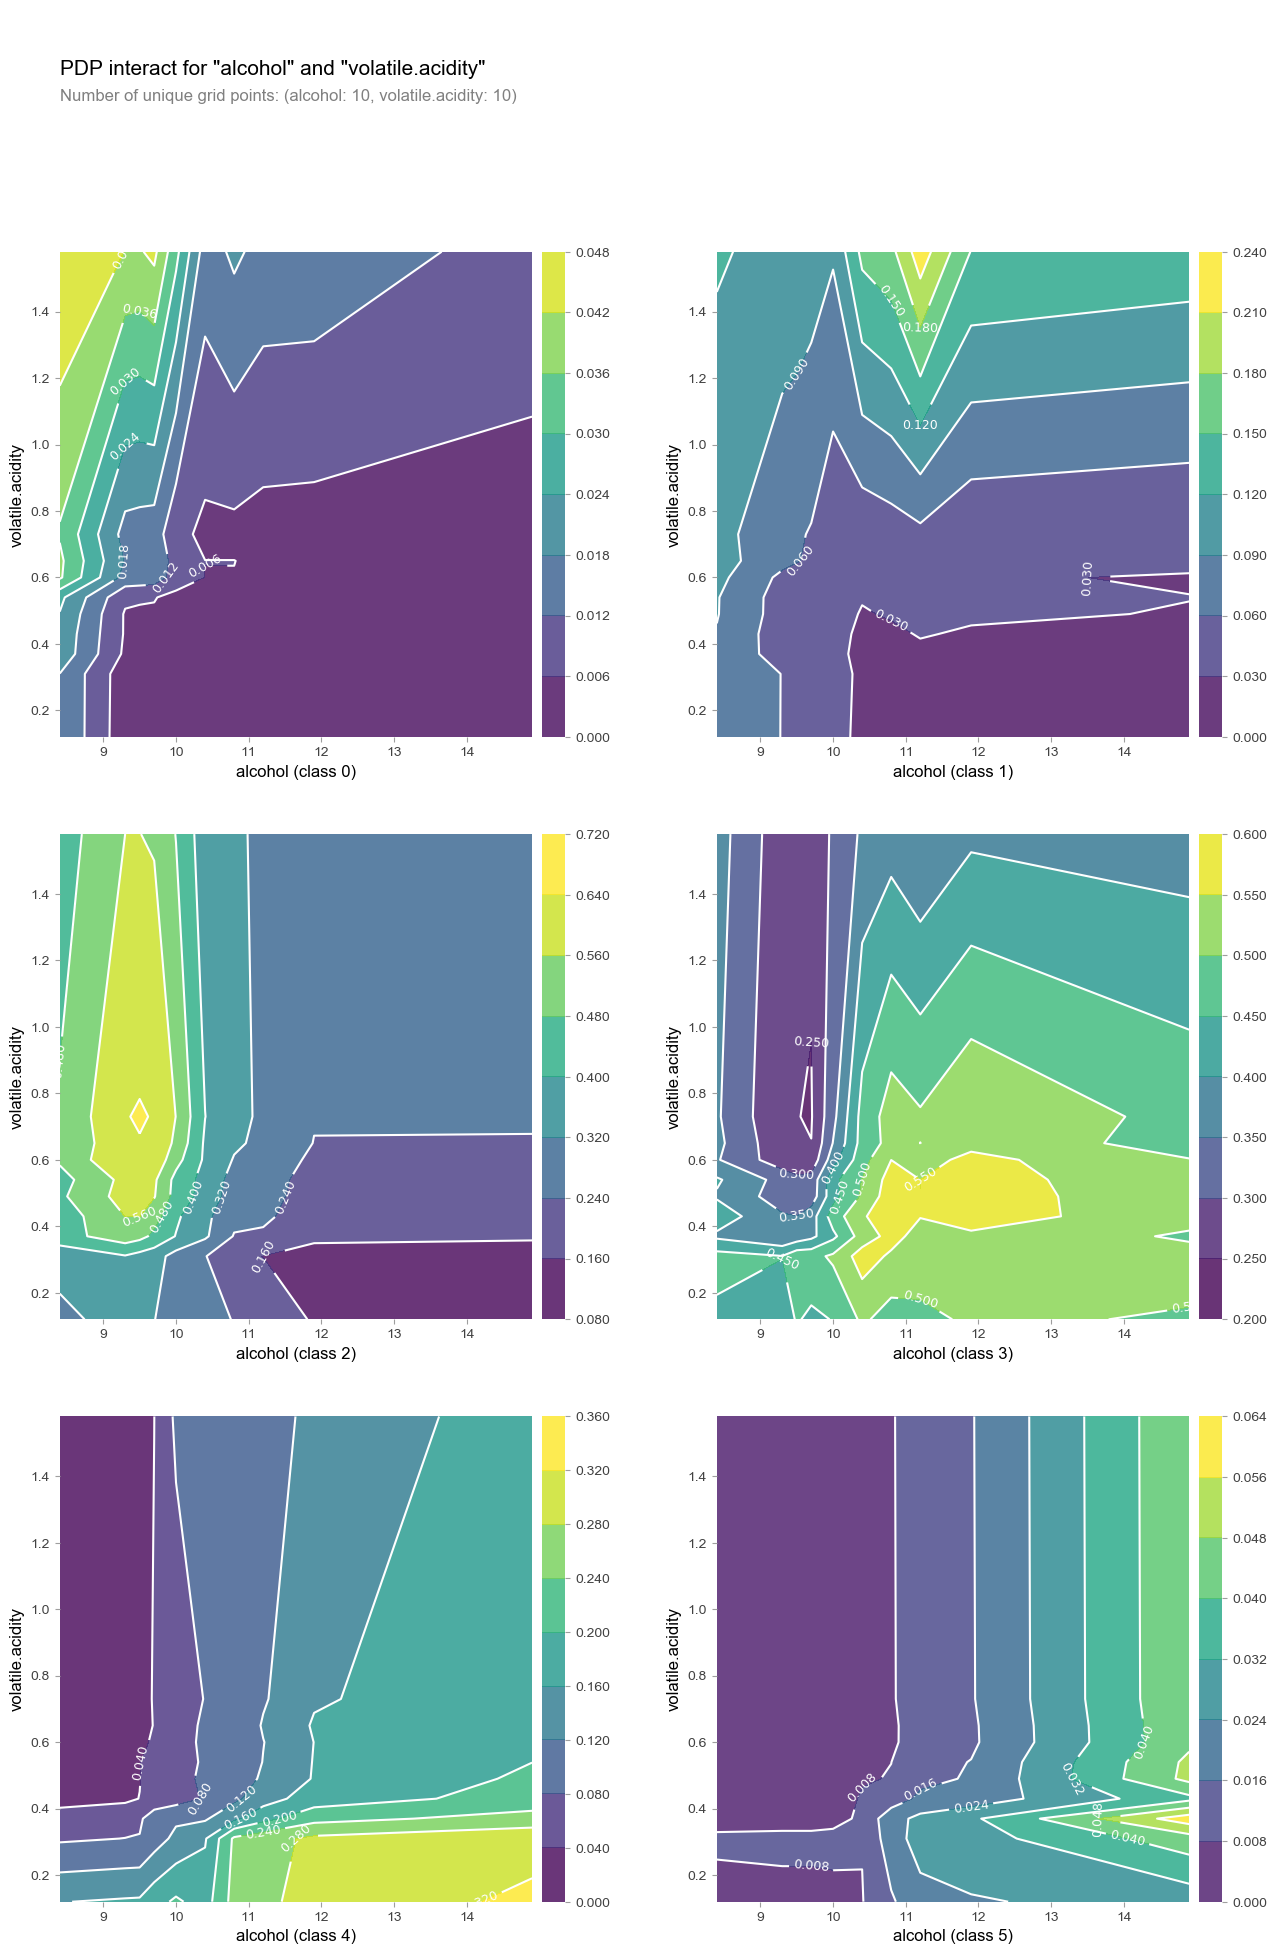

In [25]:
feats = ['alcohol', 'volatile.acidity']
p = pdp.pdp_interact(model, X_train, X_train.columns, feats)
pdp.pdp_interact_plot(p, feats)
plt.savefig("BPDP_alcohol_vol_acidity.jpeg")

# Alcohol Analysis

Given alcohol seems to be a strong driver of the quality of the wine.   
It may be informative to see what is correlated with alcohol and see if there may be insights to be made.  
In this model, density will be dropped as it is essentially a weighted average of water, alcohol and residual sugar thus inherently uninformative.


Similar to before, we can create new training and validation sets excluding the quality and density. And then set the dependent variable to be alcohol. We can then instantiate and fit a random forest regression model.

In [26]:
df_alcohol = df_raw.copy()
df_alcohol.drop(["quality","density"],axis=1,inplace = True)
X_train_alc, y_train_alc, X_valid_alc, y_valid_alc = split_df(df_alcohol, train_idx,test_idx,y_var = "alcohol")

alc_model = RandomForestRegressor(min_samples_leaf= 1, max_features= 0.9, random_state=2)
alc_model.fit(X_train_alc, y_train_alc);

Whilst it heavily underfits and the validation score is not great. It should suffice for a crude analysis.

In [27]:
print(f"Training Accuracy: {r2_score(y_train_alc,alc_model.predict(X_train_alc))}")
print(f"Validation Accuracy: {r2_score(y_valid_alc,alc_model.predict(X_valid_alc))}")

Training Accuracy: 0.9356313945468736
Validation Accuracy: 0.5319145377940129


Despite a crude analysis, we can see that fixed acidity, chlorides and total sulfur dioxide may be correlated with alcohol. These may be byproducts of a chemical function that causes alcohol but could be explored further with a hypothetical client.

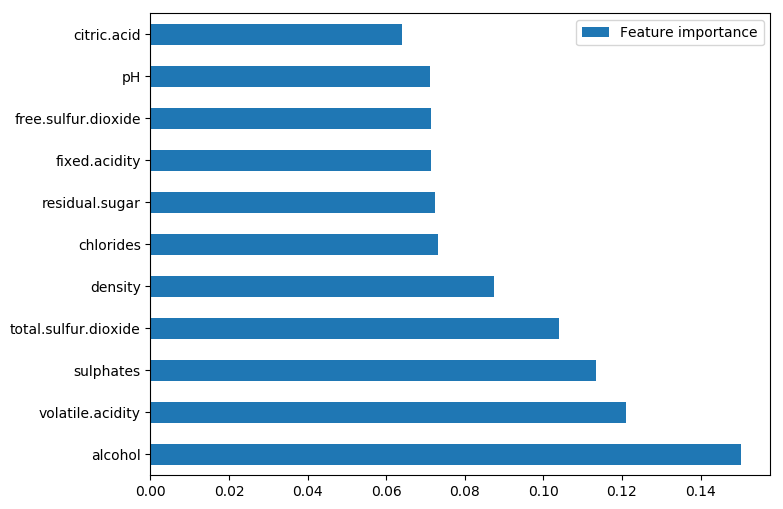

In [28]:
feat_imp = pd.DataFrame(model.feature_importances_,
                        X_train.columns,columns = ["Feature importance"]
                       ).sort_values("Feature importance", ascending = False)
plt.style.use('default')
feat_imp.plot(kind="barh",figsize = [8,6])

# Shapley Additive Explainer (Exploratory concepts)

To get a better understanding of the data. A Shapley Value can be computed

Import Shap Package

In [29]:
import shap

Given we are using a tree model we can use the TreeExplainer classes

In [30]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train, y = y_train)

## Summary Plot

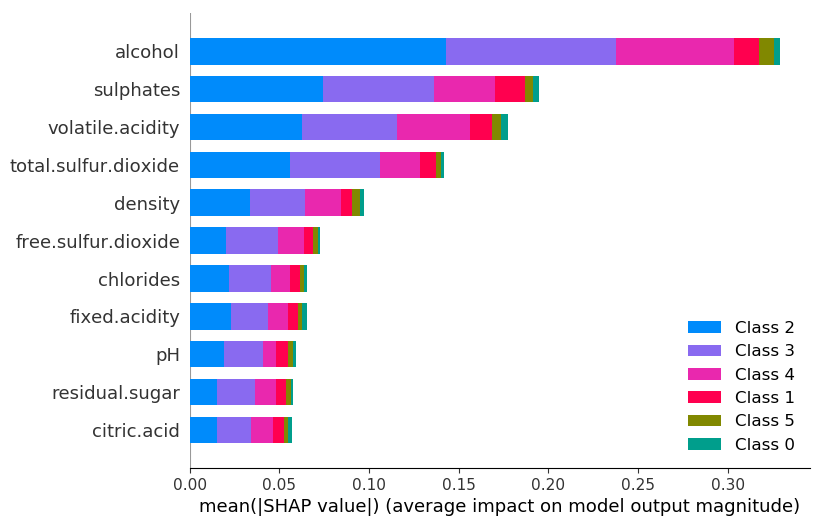

In [31]:
shap.summary_plot(shap_values, X_train)

## Shapley Feature Importance 

This gives the dimensions  
    `dependant_classes * samples * features`
   
Where the values are changes in probability associated by the value of the feature for the given class in the given sample.  
We can average the sample values such that the space become simply  
    `dependant_classes * features`
    
We can then analyse how each of the features affects the probability of the given class. In this case we are agnostic to the direction and only care about how a perbutation in the input space affects the probability of predicting a class, whether positively or negatively.

In [32]:
mean_abs_shap = np.absolute(shap_values).mean(axis=1)
mean_shap_values = pd.DataFrame(mean_abs_shap,index=[3,4,5,6,7,8],columns=X_train.columns)

The resulting dataframe gives the features as columns and the classes as the index.  
The values are aggregate change in probability given the class values

In [33]:
mean_shap_values

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
3       0.002618          0.003880     0.001870        0.001461   0.002050   
4       0.006013          0.012591     0.006116        0.005563   0.005365   
5       0.022957          0.062424     0.015250        0.015280   0.021678   
6       0.020548          0.053028     0.018731        0.021160   0.023860   
7       0.011006          0.040571     0.012251        0.011653   0.010515   
8       0.001971          0.004727     0.002544        0.002553   0.002070   

   free.sulfur.dioxide  total.sulfur.dioxide   density        pH  sulphates  \
3             0.001397              0.002206  0.002175  0.001708   0.003197   
4             0.004691              0.008714  0.006274  0.006617   0.016859   
5             0.019908              0.055905  0.033790  0.019058   0.074456   
6             0.029174              0.049927  0.030274  0.021485   0.061584   
7             0.014872              0.022650  0.020215  0.007487   0.034143   
8             0.002661              0.002638  0.004576  0.002897   0.004297   

    alcohol  
3  0.003483  
4  0.014008  
5  0.142822  
6  0.095155  
7  0.065761  
8  0.008141

For easier analysis we can view the resulting values as a bar graph for each class

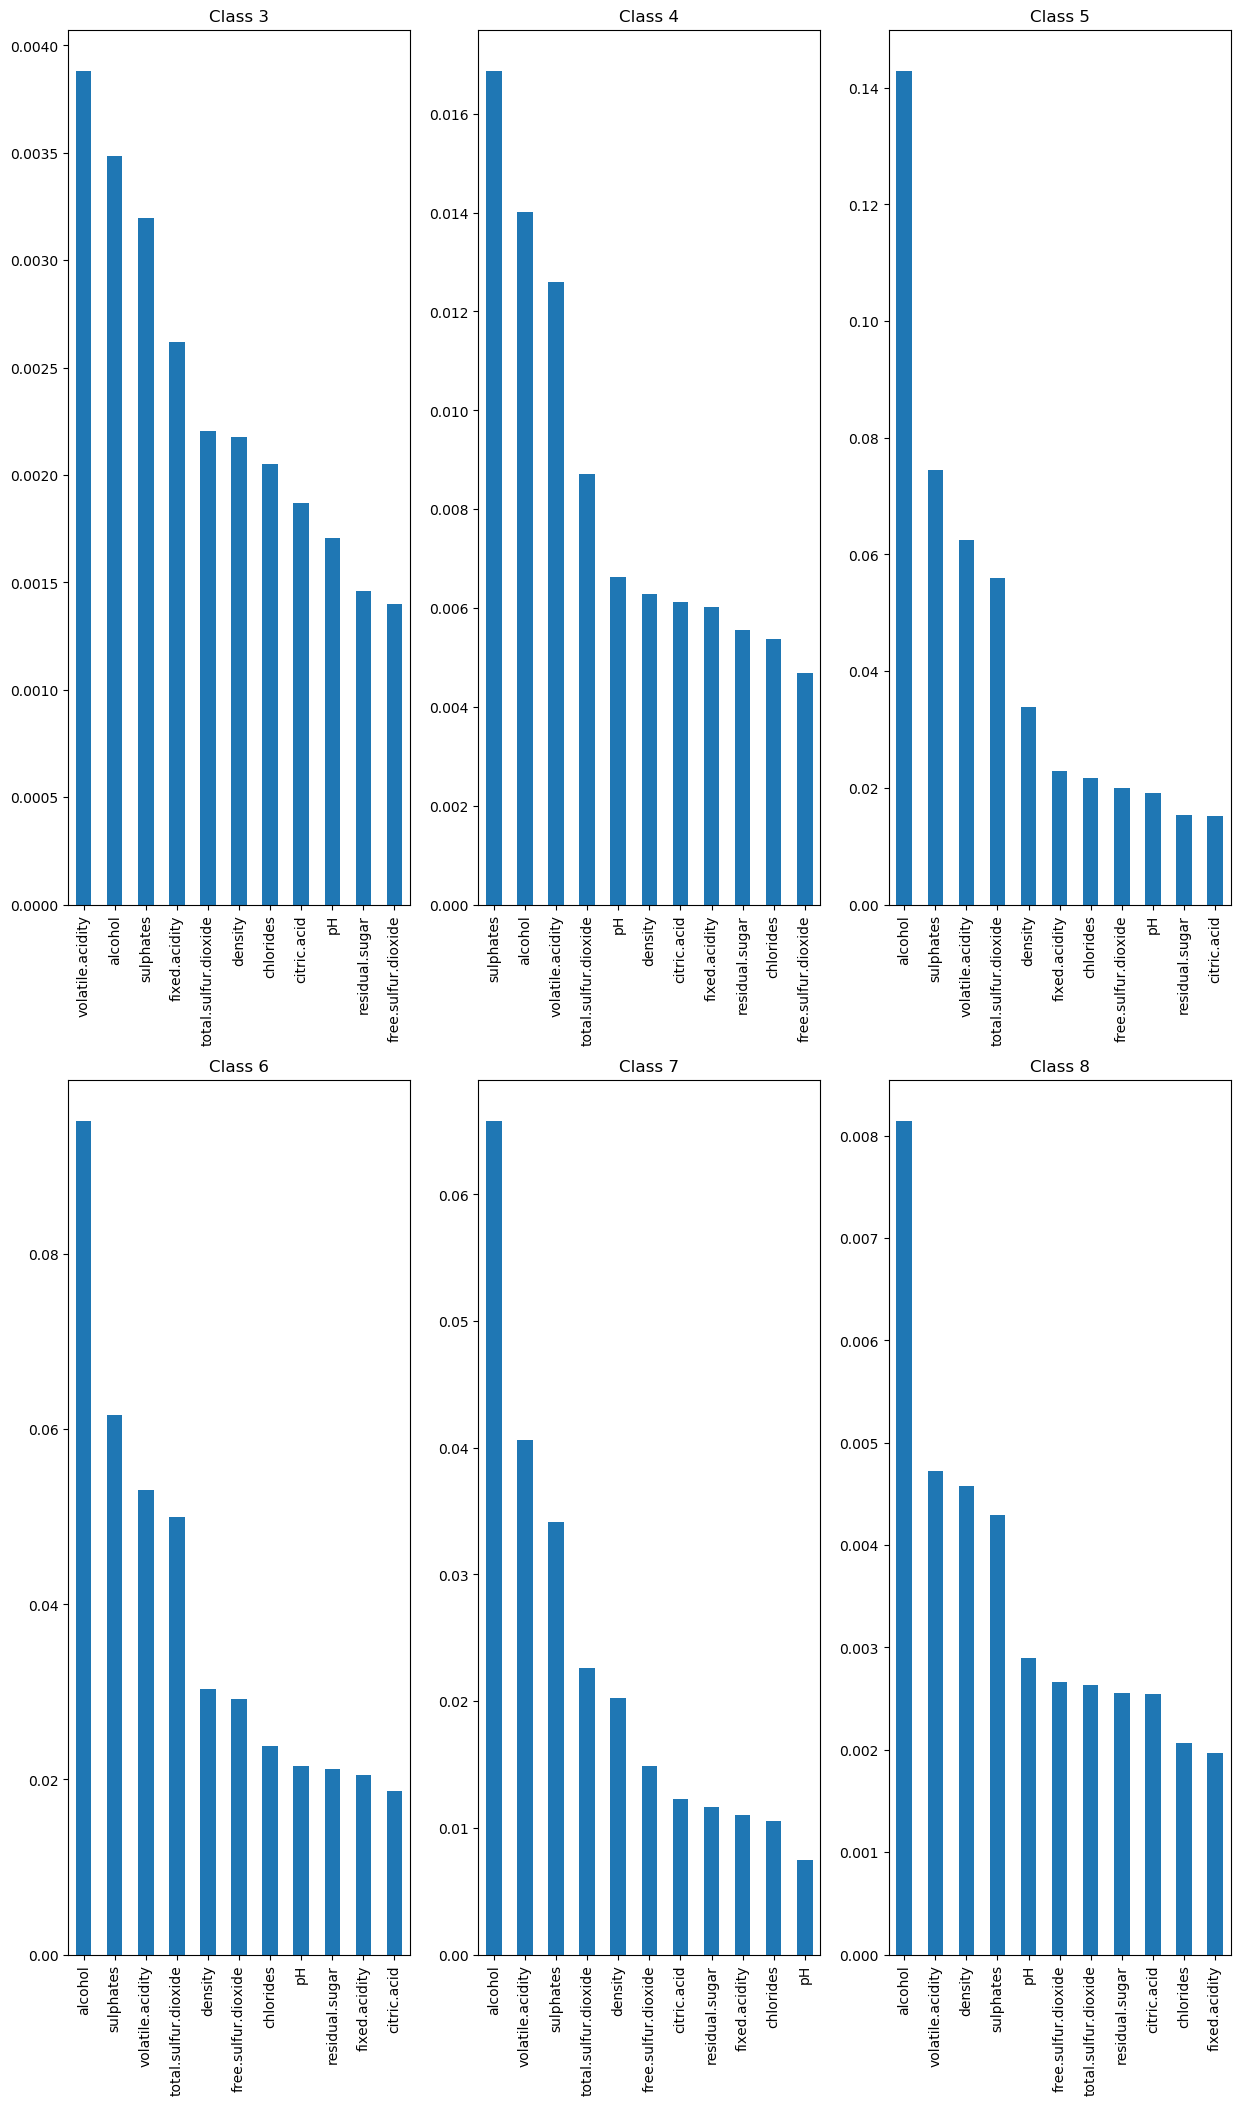

In [34]:
plt.figure(figsize=[15,25])

for i in range(mean_shap_values.shape[0]):
    plt.subplot(2, 3, i+1)
    plt.title(f"Class {i+3}")
    mean_shap_values.iloc[i].sort_values(ascending=False).plot(kind="bar")

## Shapley Feature Directional Effects  

We can repeat the analysis and determine on average whether a positive or negative value affects the predicted outcomes

In [35]:
mean_shap = np.array(shap_values).mean(axis=1)
mean_shap_values = pd.DataFrame(mean_shap,index=[3,4,5,6,7,8],columns=X_train.columns)

In [36]:
mean_shap_values

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
3      -0.000036         -0.000348    -0.000474       -0.000162   0.000027   
4       0.000888          0.000472     0.000603        0.001458  -0.000520   
5      -0.001850         -0.001791    -0.000949       -0.002066  -0.000267   
6       0.002012          0.002451     0.001283        0.000930  -0.000597   
7      -0.001944         -0.000648    -0.000145       -0.000653   0.000533   
8       0.000930         -0.000136    -0.000320        0.000493   0.000825   

   free.sulfur.dioxide  total.sulfur.dioxide   density        pH  sulphates  \
3             0.000139             -0.000117 -0.000584  0.000297   0.000408   
4             0.000795             -0.000360  0.001339  0.000529  -0.002895   
5            -0.001702              0.001626  0.003319 -0.001538   0.001148   
6             0.000693             -0.000661 -0.002430  0.001669   0.001356   
7             0.000016             -0.000772 -0.000710 -0.001206   0.000431   
8             0.000060              0.000283 -0.000934  0.000249  -0.000448   

    alcohol  
3 -0.000238  
4 -0.002439  
5  0.005764  
6 -0.005098  
7  0.001884  
8  0.000127

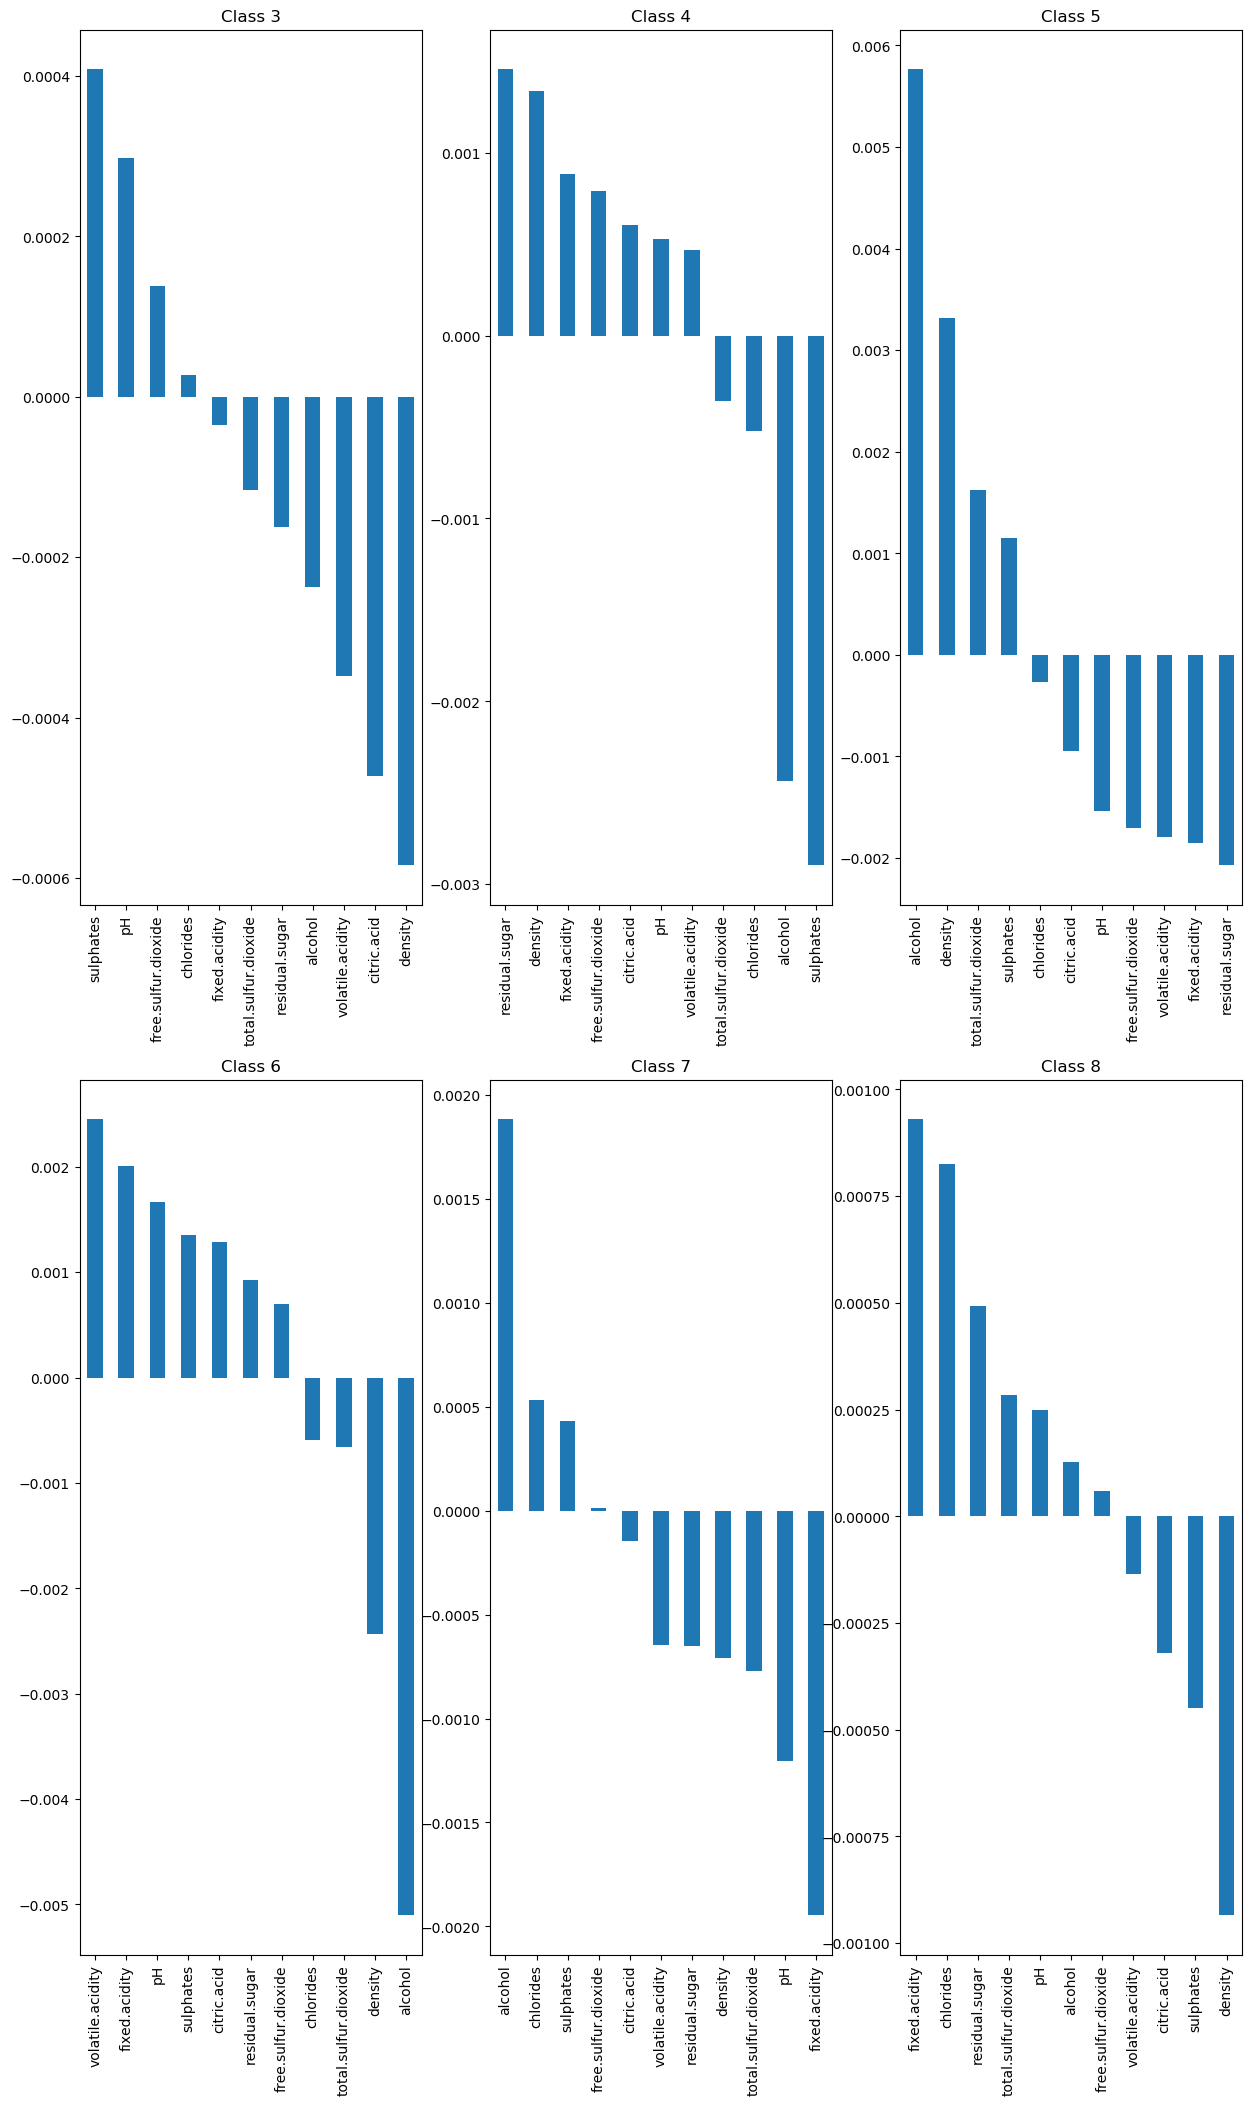

In [37]:
plt.figure(figsize=[15,25])

for i in range(mean_shap_values.shape[0]):
    plt.subplot(2, 3, i+1)
    plt.title(f"Class {i+3}")
    mean_shap_values.iloc[i].sort_values(ascending=False).plot(kind="bar")

In [38]:
# shap.force_plot(explainer.expected_value, shap_values["row"], feature_names= X_train.columns, plot_cmap="GnPR")

In [39]:
quality_value = 6

shap.initjs()
shap.force_plot(explainer.expected_value[quality_value - 3], shap_values[quality_value-3], X_train)

## Localalized Interpretable Techniques
To better understand why the models have scored the sample, the way it has. We can run the plot the shapley values for the given sample and determine hwat has caused a higher or lower feature variable for each input. 

In [40]:
sample = X_train.iloc[0]
local_shaps = explainer.shap_values(sample)

In [41]:
print(f"Prediction: {model.predict([sample])[0]} \nActual: {y_train.iloc[0]}")

Prediction: 6 
Actual: 6


In [42]:
local_shap_values = pd.DataFrame(local_shaps,index=[3,4,5,6,7,8],columns=X_train.columns)

In [43]:
local_shap_values

fixed.acidity  volatile.acidity  citric.acid  residual.sugar  chlorides  \
3       0.001189         -0.003656    -0.001144       -0.000189  -0.000590   
4      -0.002122         -0.020541    -0.012449        0.001350  -0.002148   
5      -0.008019         -0.106087    -0.004709       -0.009446  -0.007123   
6       0.005629          0.043399     0.010674        0.044695   0.025729   
7      -0.008615          0.089525     0.002448       -0.026629  -0.018335   
8       0.011938         -0.002640     0.005180       -0.009782   0.002466   

   free.sulfur.dioxide  total.sulfur.dioxide   density        pH  sulphates  \
3            -0.000370              0.001984 -0.000408 -0.000754  -0.002440   
4             0.000321              0.024820  0.007297 -0.002722  -0.009635   
5            -0.004525             -0.042966 -0.035484 -0.006228  -0.036053   
6             0.000381              0.070498 -0.002009  0.011324   0.036001   
7             0.000785             -0.050121  0.009240 -0.000740   0.012189   
8             0.003409             -0.004215  0.021363 -0.000880  -0.000061   

    alcohol  
3 -0.000963  
4 -0.019010  
5 -0.155433  
6  0.042167  
7  0.120095  
8  0.013144

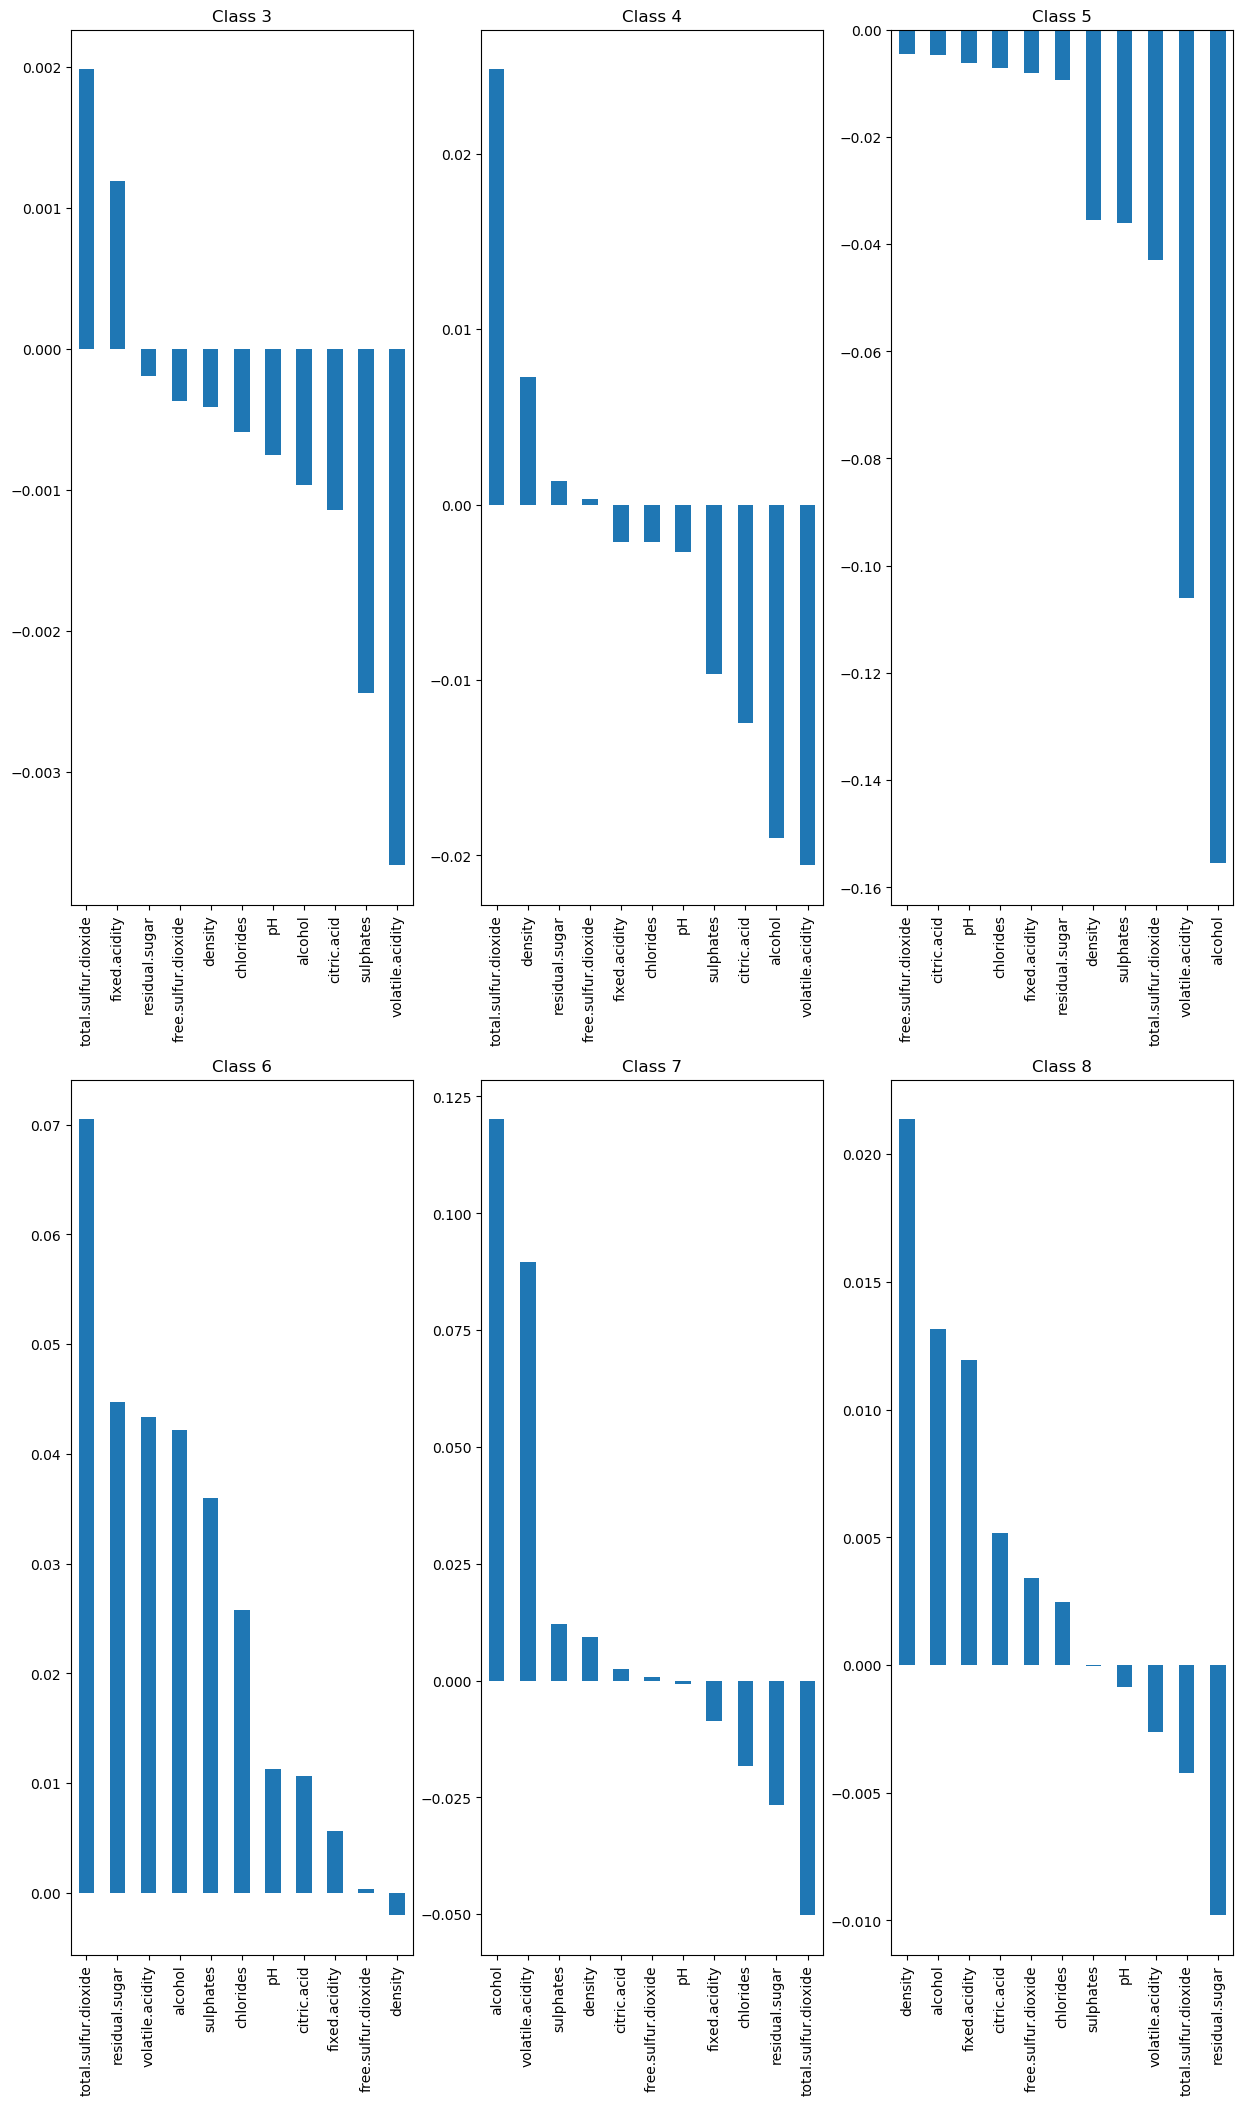

In [44]:
plt.figure(figsize=[15,25])

for i in range(local_shap_values.shape[0]):
    plt.subplot(2, 3, i+1)
    plt.title(f"Class {i+3}")
    local_shap_values.iloc[i].sort_values(ascending=False).plot(kind="bar")

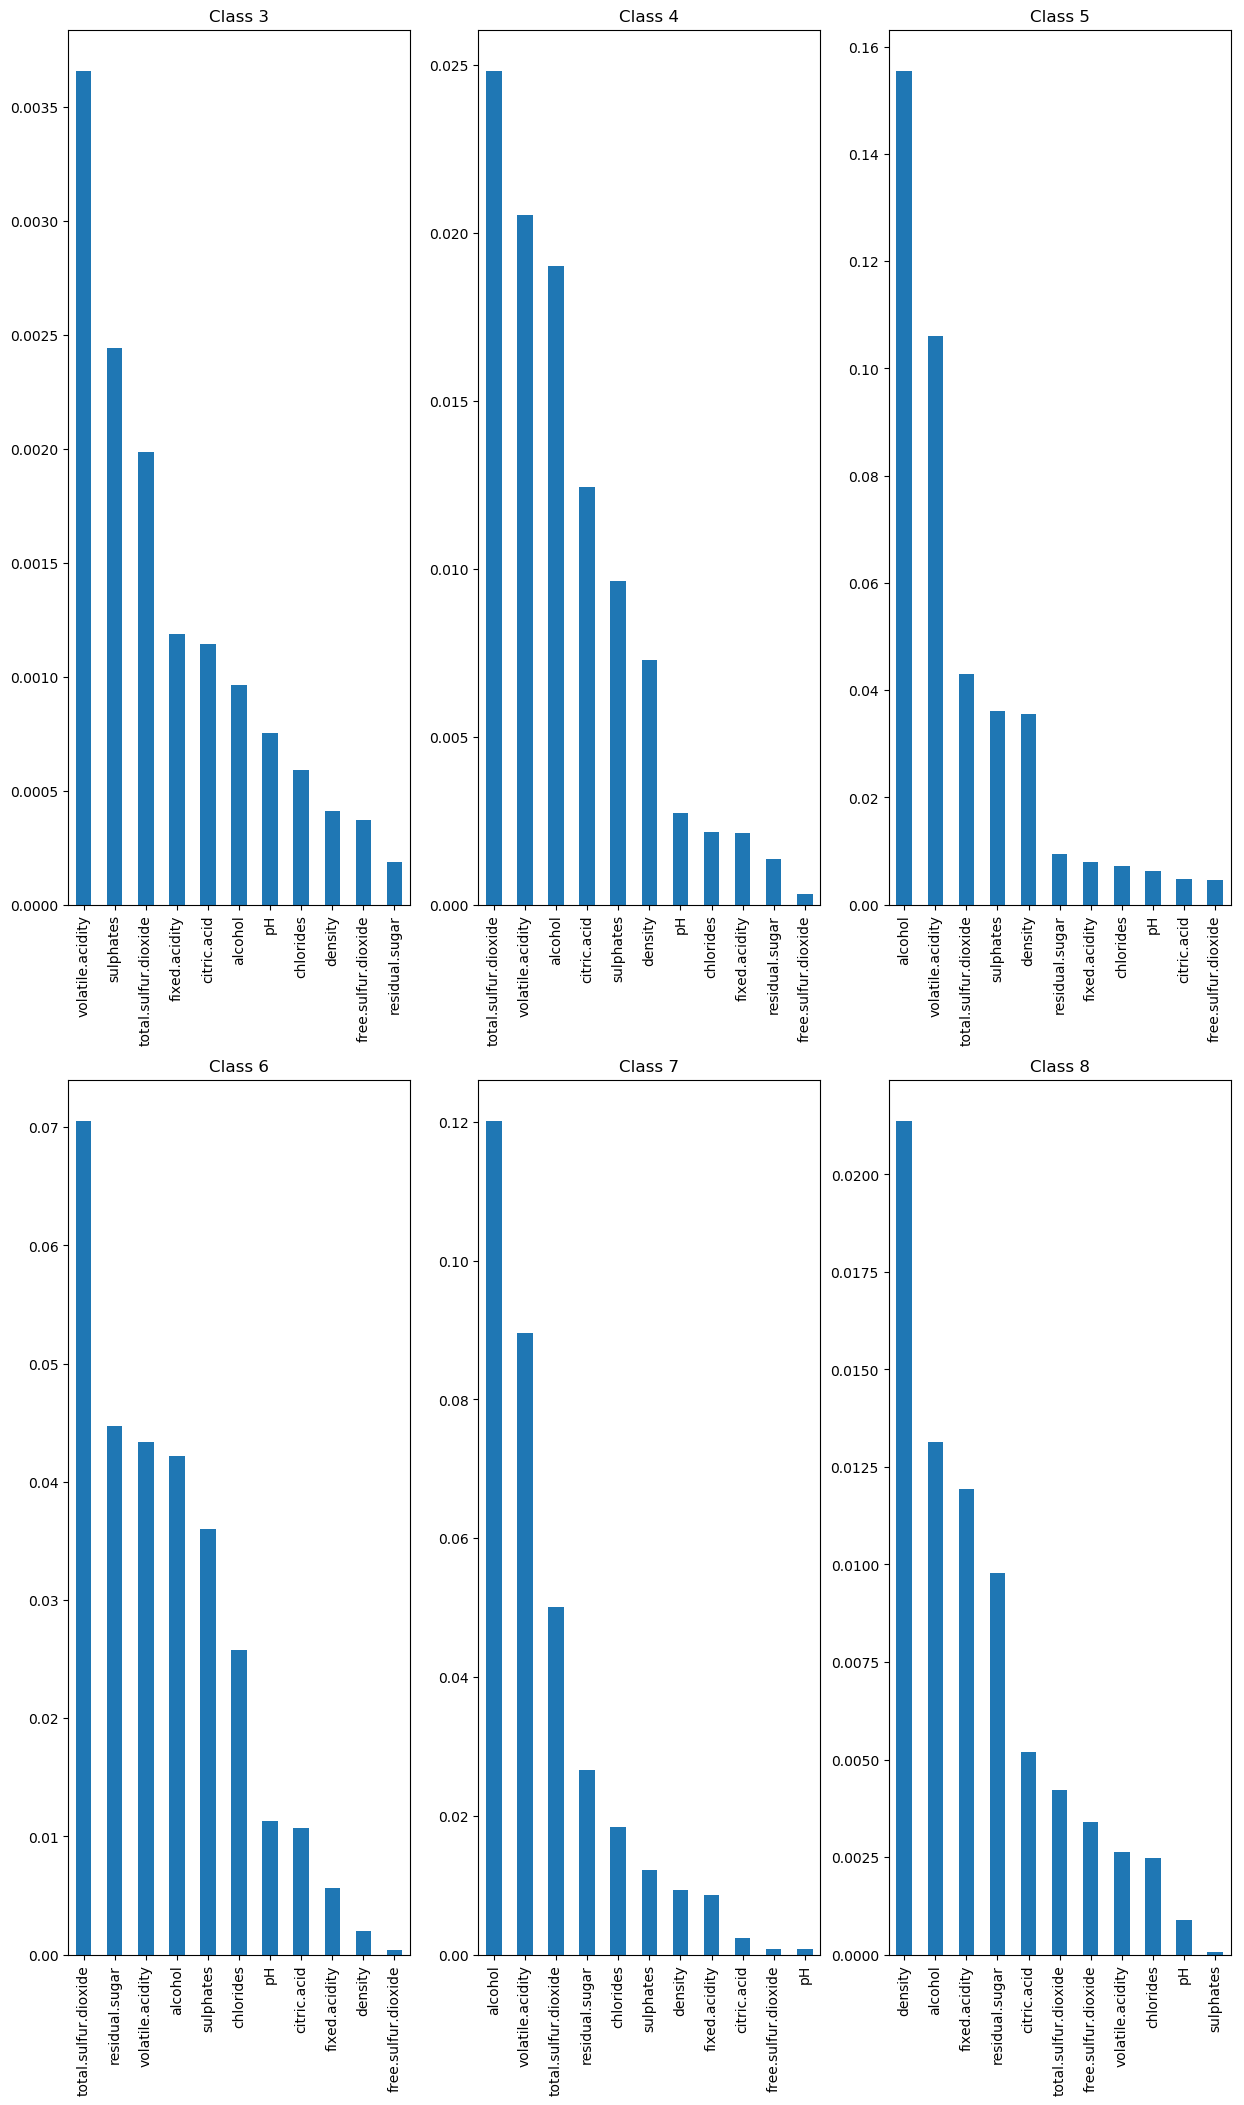

In [45]:
plt.figure(figsize=[15,25])

for i in range(local_shap_values.shape[0]):
    plt.subplot(2, 3, i+1)
    plt.title(f"Class {i+3}")
    local_shap_values.abs().iloc[i].sort_values(ascending=False).plot(kind="bar")

In [46]:
np.array(shap_values).shape

(6, 1151, 11)

In [47]:
# shap.multioutput_decision_plot(explainer.expected_value, shap_values)

In [48]:
siv = explainer.shap_interaction_values(X_train)

With an idea of how the data is being driven. A further effort can be made to design a model that will perform well for the classification task.  
Usually feature engineering will be conducted prior but in this case, there is only a limited amount of tasks that we can do. So we can combine feature engineering with model selection to find the best model and feature space to predict the quality of the wine.  